# Grover

This example shows how a minimal modification in the transpiled circuit of a 3-qubit Grover search can lead to obtaining wrong results.

This notebook is a step-by-step tutorial and gives additional insights about the example described in Sec. 7.2 of the paper.

Reproducible quantum builds would help detect and mitigate this class of attacks, as explained in the threat model section (see Sec. 5.2). In particular, if transpiled quantum circuits are always bit-for-bit identical, any small modification in the transpiled circuit could be interpreted as a bug potentially affecting the results of the quantum computation.

<div class="alert alert-block alert-info">
It is assumed that you have already configured your token to use IBM Quantum Platform. If not, follow <a href="https://quantum.cloud.ibm.com/docs/en/migration-guides/classic-iqp-to-cloud-iqp#onboard">IBM's instructions here</a>.
</div>
<div class="alert alert-block alert-danger">
This notebook contains cells that will submit jobs to the <a href="https://quantum.cloud.ibm.com/">IBM Quantum Platform</a>. Running these jobs may incur costs if you are on a paid plan.
    
By default, the boolean <code>run_on_ibm</code> prevents these cells from executing. Set it to <code>True</code> to enable execution.
</div>

## Index

1. [Grover circuit](#Grover-circuit)
2. [Modifying a single CZ gate](#Modifying-a-single-CZ-gate)
3. [Running on a real backend](#Running-on-a-real-backend)

In [1]:
import qiskit
import qiskit_ibm_runtime

print(f"Qiskit version: {qiskit.version.get_version_info()}")
print(f"Qiskit IBM Runtime version: {qiskit_ibm_runtime.version.get_version_info()}")

Qiskit version: 2.2.1
Qiskit IBM Runtime version: 0.42.0


In [2]:
run_on_ibm = False
# Number of times quantum circuits are executed on IBM's quantum backend
n_shots = 10_000

---

## Grover circuit

The problem that Grover's algorithm addresses is the following: There is an (unknown) function $f$, which maps $n$-bit strings $x$ to bits, i.e., $f:\{0,1\}^n\rightarrow \{0,1\}$. There is one or more inputs $x_i$, out of the $2^n=N$ possible ones, for which the function returns $1$. Find these $x_i$!

Grover's algorithm is formulated as a query problem, where one is able to query the function $f$, but knows nothing else about the function. I.e., for a certain $x$, it is possible to ask the oracle "What is $f(x)$?". In the quantum case, the oracle must of course be a "quantum oracle" and we can query it in superposition.

The following circuit implements a quantum oracle that marks as "good" the strings (or states) "101" and "110".

In [3]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import MCMTGate, ZGate

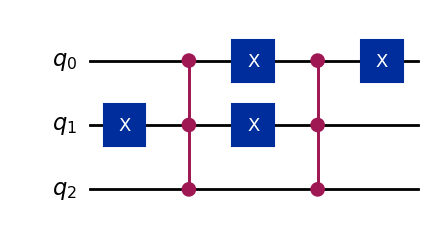

In [4]:
qc_oracle = QuantumCircuit(3)
# Marks state 101
qc_oracle.x(1)
qc_oracle.ccz(0, 1, 2)
qc_oracle.x(1)
# Marks state 110
qc_oracle.x(0)
qc_oracle.ccz(0, 1, 2)
qc_oracle.x(0)
qc_oracle.draw("mpl")

This circuit is equivalent to the [`PhaseOracle`](https://quantum.cloud.ibm.com/docs/en/api/qiskit/qiskit.circuit.library.PhaseOracle) implemented in Qiskit.

In [5]:
from qiskit.circuit.library import PhaseOracleGate

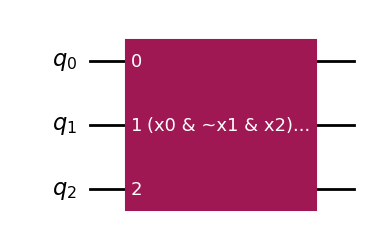

In [6]:
qc_oracle_equiv = QuantumCircuit(3)
qc_oracle_equiv.compose(PhaseOracleGate("(x0 & ~x1 & x2) | (~x0 & x1 & x2)"), inplace=True)
qc_oracle_equiv.draw("mpl")

The full Grover circuit is composed of two parts or subroutines:

1. The quantum oracle of the function $f$
2. The "diffusion operator"

The first part of the circuit queries the function $f$ and the second part, which can be called one or more times, "amplifies" the good or marked states. The diffusion operator should be applied a certain number of times to get the correct solutions. Using this operator more or less times than the optimal, might lead to wrong answers. This number depends on the total number of possible inputs and the number or marked states (e.g., exactly the opposite). However, it is possible to get this optimal number efficiently, e.g., with quantum counting.

The diffusion operator is implemented in Qiskit, and the circuit below shows how to create a full Grover circuit using the oracle from above.

In [7]:
from qiskit.circuit.library import grover_operator

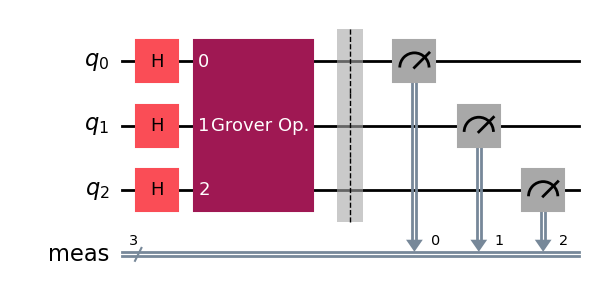

In [8]:
grover_op = grover_operator(qc_oracle, name="Grover Op.")
qc_grover = QuantumCircuit(grover_op.num_qubits)
qc_grover.h(range(grover_op.num_qubits))
qc_grover.compose(grover_op.power(1), inplace=True)
qc_grover.measure_all()
display(qc_grover.draw("mpl"))

Now we transpile the circuit using as target the [`ibm_torino`](https://quantum.cloud.ibm.com/computers?system=ibm_torino) 133-qubit backend.

In [9]:
from qiskit import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime.fake_provider import FakeTorino

In [10]:
backend = FakeTorino()

If you have an IBM Quantum Platform account and have followed [the instructions to configure and save it](https://quantum.cloud.ibm.com/docs/en/guides/cloud-setup), you can uncomment the cell below to use the latest noise model from a real quantum backend. Otherwise, feel free to continue with the rest of the notebook using the noise model from the old snapshot.

In [11]:
#service = QiskitRuntimeService()
#backend = service.backend("ibm_torino")

We fix a random seed for reproducibility.

In [12]:
import secrets

In [13]:
# Random seed fixed for reproducibility. Delete the fixed seed and uncomment the next line for a fresh random seed.
# seed = secrets.randbits(64)
seed = 13922476891334822750

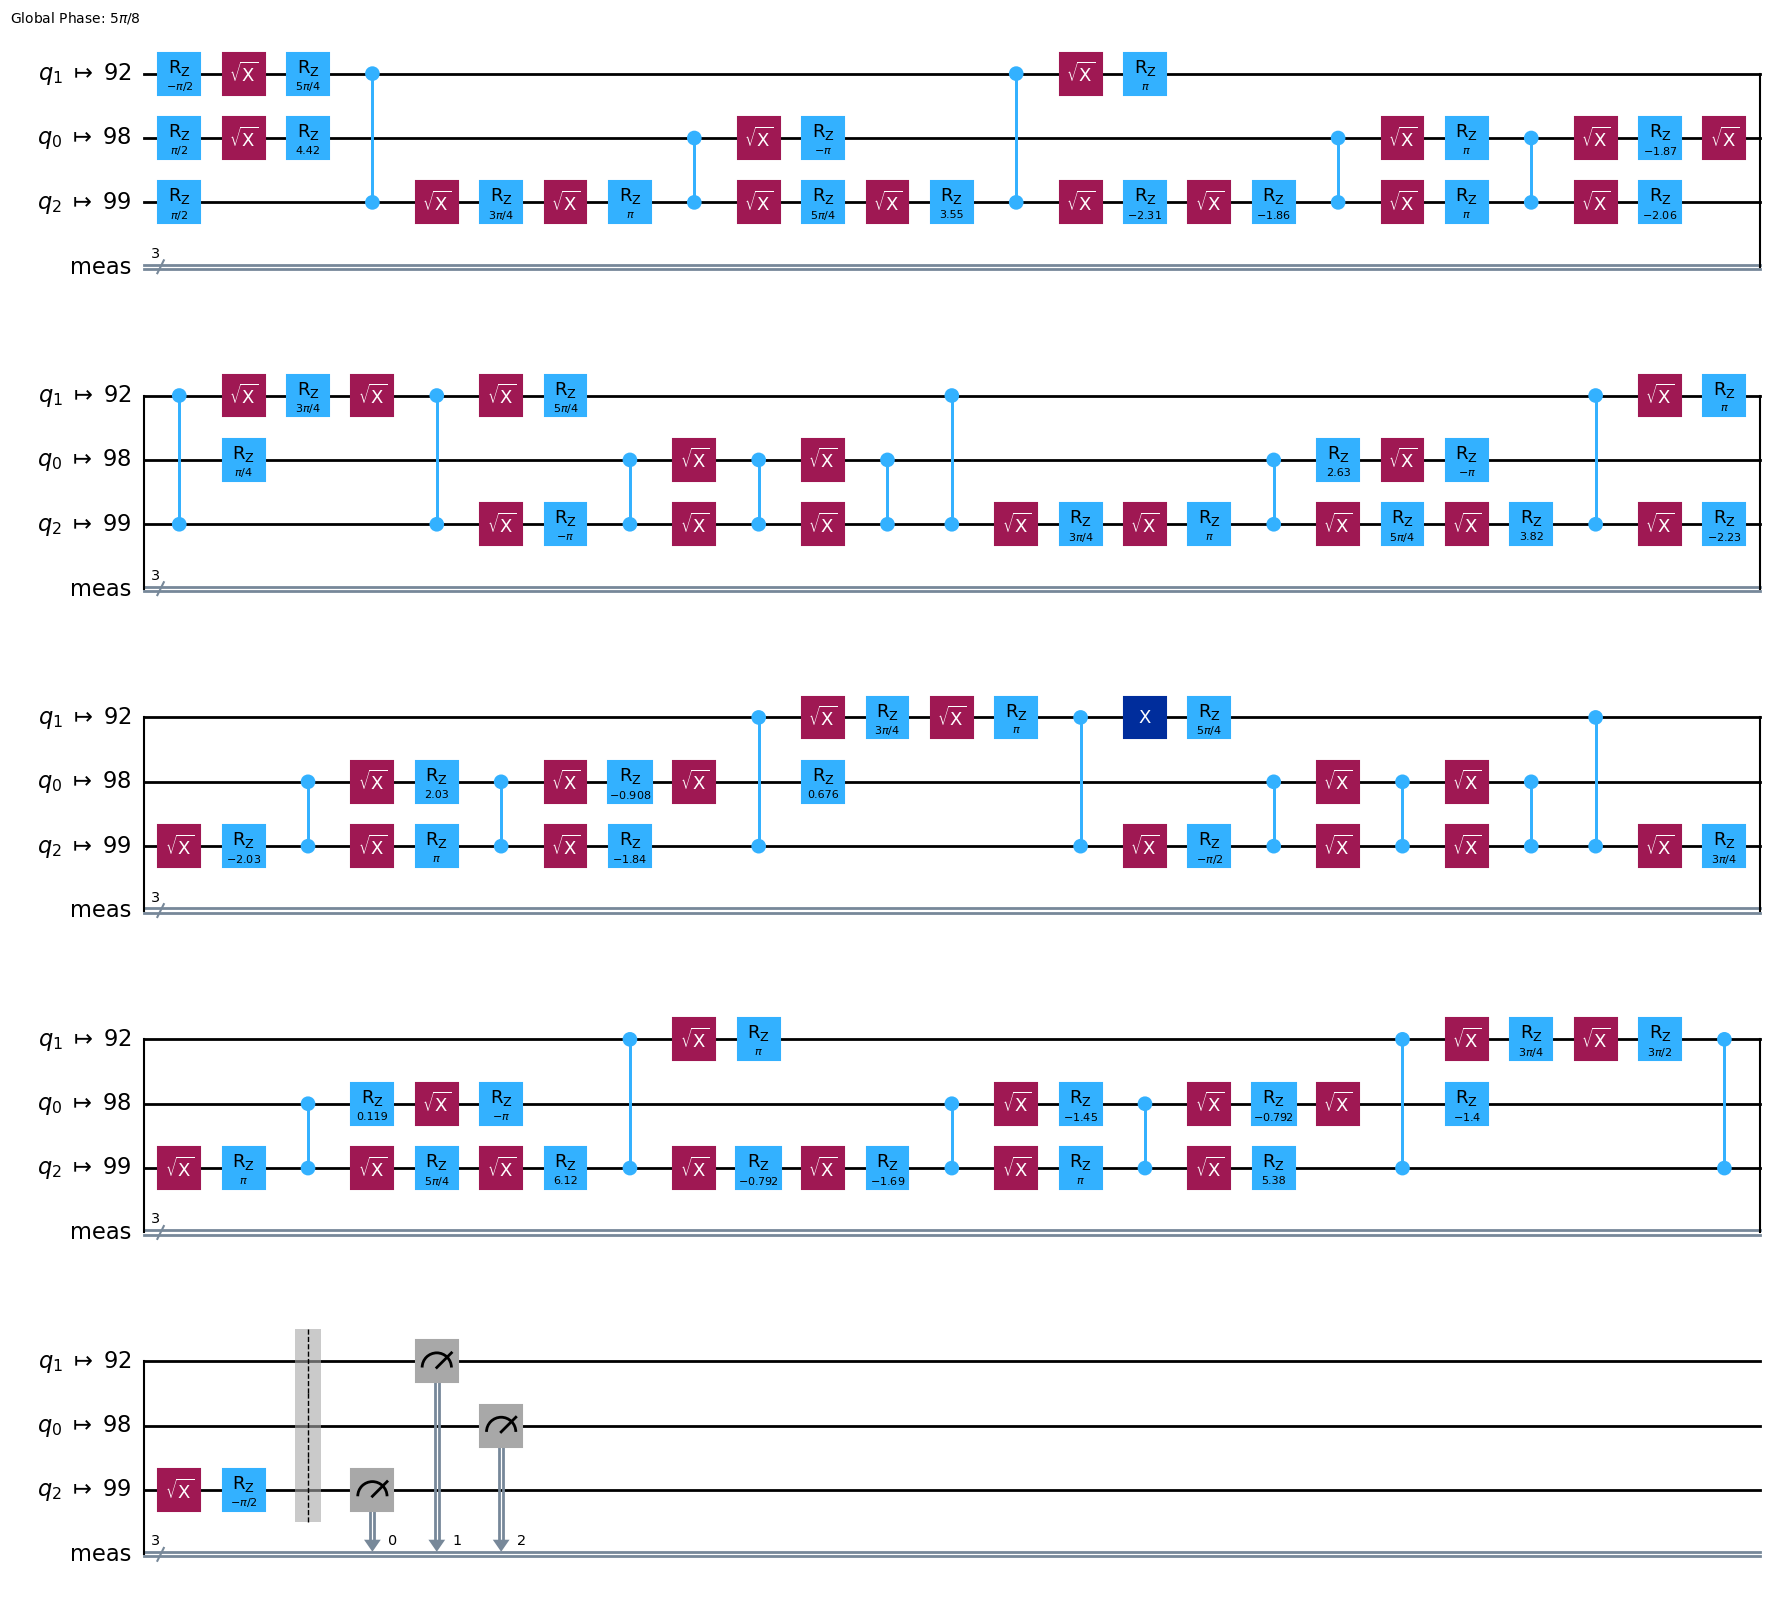

In [14]:
pm = generate_preset_pass_manager(backend=backend, optimization_level=3, seed_transpiler=seed)
isa_qc_grover = pm.run(qc_grover)
isa_qc_grover = pm.run(qc_grover)
isa_qc_grover.draw("mpl")

## Modifying a single CZ gate

Even though we are doing just a 3-qubit Grover circuit, the transpiled circuit is already quite complex.

In [15]:
print(f"depth = {isa_qc_grover.depth()}")
print(f"size  = {isa_qc_grover.size()}")

depth = 100
size  = 146


However, modifying a single instruction can lead to wrong results. For example, we could replace the qubits involed in any of the CZ gates. Let's change the last one, for example.

In [16]:
for i, ins in enumerate(isa_qc_grover.data):
    if ins.operation.name == "cz":
        target_instruction = i

In [17]:
from qiskit.circuit import CircuitInstruction
from qiskit.circuit.library import CZGate

The last controlled-Z gate is applied in the original circuit to qubits 66 and 67, while in the modified circuit it is applied to qubits 65 and 66.

In [18]:
isa_qc_grover_mod = isa_qc_grover.copy()
print(isa_qc_grover.data[target_instruction])
del isa_qc_grover_mod.data[target_instruction]
isa_qc_grover_mod.data.insert(target_instruction, CircuitInstruction(CZGate(), qubits=[65, 66]))
print(isa_qc_grover_mod.data[target_instruction])

CircuitInstruction(operation=Instruction(name='cz', num_qubits=2, num_clbits=0, params=[]), qubits=(<Qubit register=(133, "q"), index=99>, <Qubit register=(133, "q"), index=92>), clbits=())
CircuitInstruction(operation=Instruction(name='cz', num_qubits=2, num_clbits=0, params=[]), qubits=(<Qubit register=(133, "q"), index=65>, <Qubit register=(133, "q"), index=66>), clbits=())


To validate the attack, we first simulate locally the full Grover circuit. This is possible since this is a very small toy example using only 3 qubits. We use the latest noise model from the real backend and we use the Qiskit `SamplerV2` implementation from Qiskit Aer.

In [19]:
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit_aer.primitives import SamplerV2 as Sampler

In [20]:
noise = NoiseModel.from_backend(backend)
sim = AerSimulator(noise_model=noise)
sampler = Sampler.from_backend(sim)

In [21]:
result = sampler.run([isa_qc_grover, isa_qc_grover_mod], shots=1000).result()
counts_sim = result[0].data.meas.get_counts()
counts_sim_mod = result[1].data.meas.get_counts()

In [22]:
from qiskit.visualization import plot_histogram

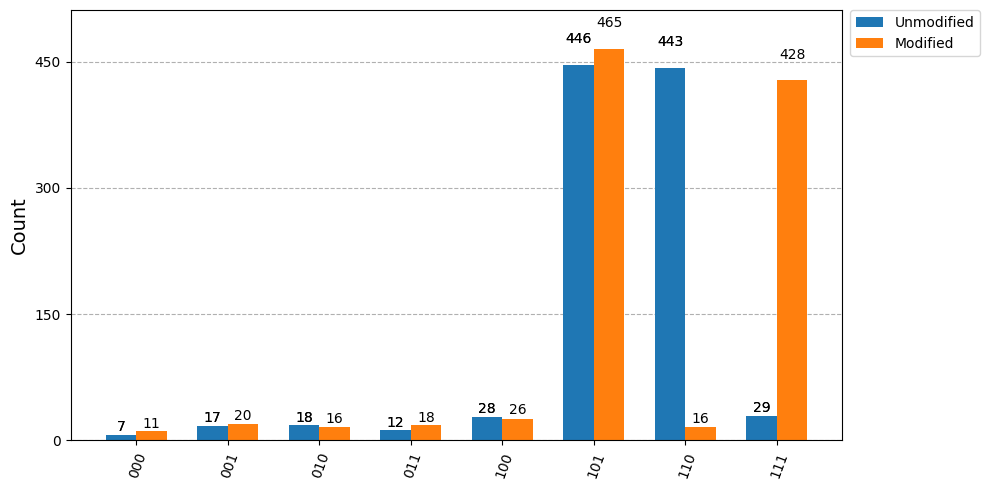

In [23]:
plot_histogram([counts_sim, counts_sim_mod], legend=["Unmodified", "Modified"], figsize=(10,5))

The unmodified circuit gives the correct results: States "101" and "110" are obtained much more frequently that the rest. These are the the states we marked with our quantum oracle. However, the single modification changes one of the "good" states, and now the two results are "101" and "111".

## Running on a real backend

Finally, we validate the local simulation by running the modified full Grover circuit on the real quantum backend "ibm_torino" available in the Open Plan from the IBM Quantum Platform.

In [24]:
from qiskit_ibm_runtime import SamplerV2 as SamplerIBM

In [25]:
sampler_ibm = SamplerIBM(backend)

In [26]:
if run_on_ibm:
    job = sampler_ibm.run([isa_qc_grover, isa_qc_grover_mod], shots=n_shots)
    job_id = job.job_id()
    print(f"job id: {job_id}")

In [27]:
if run_on_ibm:
    job = service.job(job_id)
    job.wait_for_final_state()
    results = job.result()
    counts_unmodified = results[0].data.meas.get_counts()
    counts_modified = results[1].data.meas.get_counts()

In [28]:
if run_on_ibm:
    display(plot_histogram([counts_real, counts_real_mod], legend=["Unmodified", "Modified"], figsize=(10, 5), bar_labels=False))

The results from the quantum computer agree with the local simulation and shows that a minimal modification in the transpiled circuit can critically affect the integrity of the results.